Processing file: VISE_Poisson\OUTCAR_0.00
Processing file: VISE_Poisson\OUTCAR_0.10
Processing file: VISE_Poisson\OUTCAR_0.25
Processing file: VISE_Poisson\OUTCAR_0.35
Processing file: VISE_Poisson\OUTCAR_0.50
Processing file: VISE_Poisson\OUTCAR_0.75
Processing file: VISE_Poisson\OUTCAR_1.00
Processing file: VISE_Poisson\OUTCAR_1.25
Processing file: VISE_Poisson\OUTCAR_1.50
Processing file: VISE_Poisson\OUTCAR_1.75
Processing file: VISE_Poisson\OUTCAR_2.00
Processing file: VISE_Poisson\OUTCAR_2.25
Processing file: VISE_Poisson\OUTCAR_2.50


C:\Users\20210812\AppData\Local\Temp\ipykernel_7232\4155235479.py:71: RuntimeWarning: divide by zero encountered in divide
  wavelength_array = (h * c / (energy_array * eV_to_J)) * 1e9  # Convert meters to nm


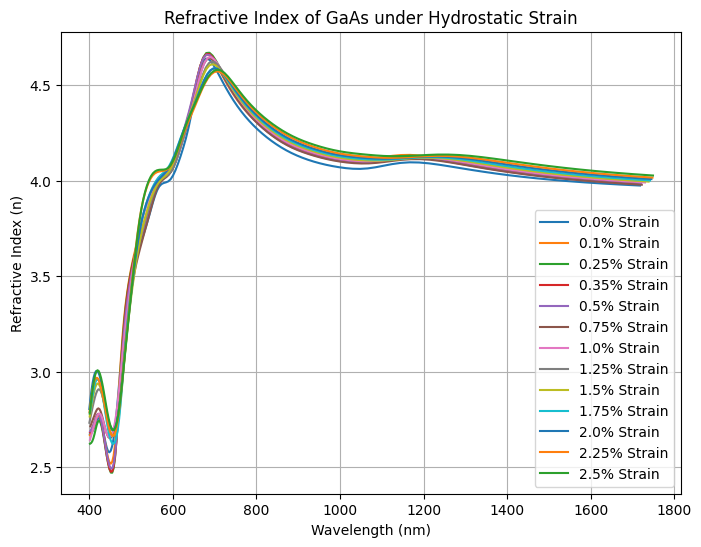

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# List of OUTCAR files (filenames OUTCAR_0, OUTCAR_50, etc.)
outcar_files = sorted(glob.glob("VISE_Poisson/OUTCAR_*"))

h = 6.62607015e-34
c = 2.998e8
eV_to_J = 1.60218e-19

all_wavelengths = []
all_refractive_indices = []
pstress_values = [0.00, 0.10, 0.25, 0.35, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50]  # %

for file in outcar_files:
    with open(file, "r") as OUTCAR:
        data_real = []
        data_img = []
        energy_array = []

        print(f"Processing file: {file}")

        #  Real Dielectric Function
        found_real = False
        for line in OUTCAR:
            if "frequency dependent      REAL DIELECTRIC FUNCTION (independent particle, no local field effects) current-current" in line:
                found_real = True
                next(OUTCAR)  # Skip column header
                next(OUTCAR)  # Skip separator
                break

        if not found_real:
            print(f"Warning: REAL dielectric function not found in {file}")
            continue

        # Read the dielectric function values
        for line in OUTCAR:
            if line.strip() == "":
                break
            
            # Use regex to correctly split the values, somehow this was needed
            values = re.split(r'\s+|(?<=\d)(?=-)', line.strip())

            # Ensure we have enough values before conversion
            if len(values) < 3:
                print(f"Skipping invalid line in {file}: {line}")
                continue  

            try:
                values = list(map(float, values))  # Convert to floats
            except ValueError:
                print(f"Error converting line to floats in {file}: {line}")
                continue  

            energy_array.append(values[0])  # Energy (eV)
            data_real.append(values[1])  # ε_xx real part
            data_img.append(values[2])  # ε_xx imaginary part

        # Convert to NumPy arrays
        energy_array = np.array(energy_array)
        data_real = np.array(data_real)
        data_img = np.array(data_img)

        if len(data_real) == 0 or len(data_img) == 0:
            print(f"Error: No dielectric data extracted from {file}")
            continue

        # Convert energy to wavelength (nm)
        wavelength_array = (h * c / (energy_array * eV_to_J)) * 1e9  # Convert meters to nm

        # Compute refractive index
        refractive_index_array = np.sqrt((np.sqrt(data_real**2 + data_img**2) + data_real) / 2)

        # Limit wavelength range (optional)
        mask = (wavelength_array >= 400) & (wavelength_array <= 1750)
        wavelength_array = wavelength_array[mask]
        refractive_index_array = refractive_index_array[mask]

        all_wavelengths.append(wavelength_array)
        all_refractive_indices.append(refractive_index_array)

# Check if data was collected
if not all_refractive_indices:
    print("No valid refractive index data extracted. Check OUTCAR files.")
else:
    plt.figure(figsize=(8, 6))
    for i, (wavelengths, refractive_indices) in enumerate(zip(all_wavelengths, all_refractive_indices)):
        plt.plot(wavelengths, refractive_indices, label=f"{pstress_values[i]}% Strain")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Refractive Index (n)")
    plt.title("Refractive Index of GaAs under Hydrostatic Strain")
    plt.legend()
    plt.grid(True)
    plt.show()


In [2]:
print("First few original wavelengths:", all_wavelengths[0][:5])

First few original wavelengths: [1546.09665946 1508.38588381 1472.47265927 1438.22978433 1405.54178035]


[ 400  425  450  475  500  525  550  575  600  625  650  675  700  725
  750  775  800  825  850  875  900  925  950  975 1000 1025 1050 1075
 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425
 1450 1475 1500 1525 1550 1575]


C:\Users\20210812\AppData\Local\Temp\ipykernel_7232\1980802802.py:49: RuntimeWarning: divide by zero encountered in divide
  wavelength_array = (1.2398 / energy_array) * 1e3  # Convert from eV to nm


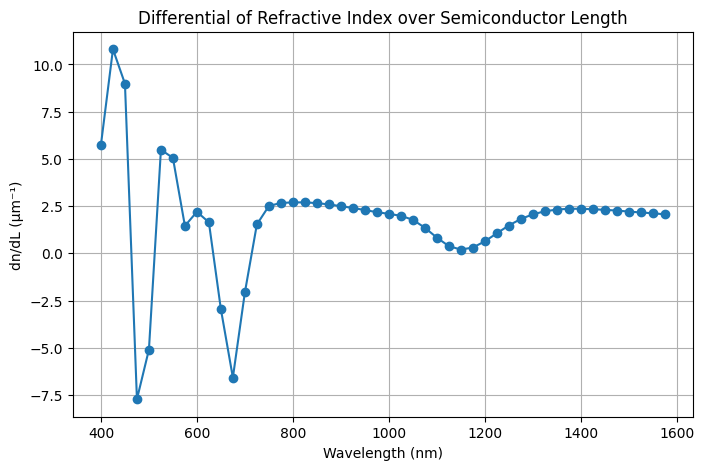

In [49]:
from scipy.stats import linregress

initial_length = 1  # µm

# Convert strain % to semiconductor lengths (L = L0 * (1 + strain/100))
semiconductor_lengths = [initial_length * (1 + pstress / 100) for pstress in pstress_values]

# Wavelength range: 400 - 1550 nm (steps of 25 nm)
target_wavelengths = np.arange(400, 1600, 25)
print(target_wavelengths)
# Store refractive indices for each strain condition
all_refractive_indices = []

for file in outcar_files:
    with open(file, "r") as OUTCAR:
        energy_array = []
        data_real = []
        data_img = []

        for line in OUTCAR:
            if "frequency dependent      REAL DIELECTRIC FUNCTION (independent particle, no local field effects) current-current" in line:
                next(OUTCAR)  # Skip column header
                next(OUTCAR)  # Skip separator
                break

        # Read dielectric function values
        for line in OUTCAR:
            if line.strip() == "":
                break
            values = line.split()
            try:
                energy_array.append(float(values[0]))  # Energy (eV)
                data_real.append(float(values[1]))  # ε_xx real part
                data_img.append(float(values[2]))  # ε_xx imaginary part
            except ValueError:
                print(f"Skipping malformed line in {file}: {line}")
                continue

        # Convert to NumPy arrays
        energy_array = np.array(energy_array)
        data_real = np.array(data_real)
        data_img = np.array(data_img)

        if len(data_real) == 0 or len(data_img) == 0:
            print(f"Error: No dielectric data extracted from {file}")
            continue

        # Convert energy to wavelength (in nm)
        wavelength_array = (1.2398 / energy_array) * 1e3  # Convert from eV to nm

        # Compute refractive index
        refractive_index_array = np.sqrt((np.sqrt(data_real**2 + data_img**2) + data_real) / 2)

        # Interpolate refractive indices to target wavelengths
        interpolated_indices = np.interp(target_wavelengths, wavelength_array[::-1], refractive_index_array[::-1])
        all_refractive_indices.append(interpolated_indices)

# Convert to NumPy array for easier handling
all_refractive_indices = np.array(all_refractive_indices)  # Shape: (num_strains, num_wavelengths)

# Compute dn/dL for each wavelength
dndl_values = [] 

for i, wavelength in enumerate(target_wavelengths):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(semiconductor_lengths, all_refractive_indices[:, i])
    dndl_values.append((wavelength, slope))  # Store wavelength and dn/dL

# Convert to NumPy array
wavelengths, dndl = np.array(dndl_values).T

# Plot dn/dL vs wavelength
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, dndl, marker='o', linestyle='-')
plt.xlabel("Wavelength (nm)")
plt.ylabel("dn/dL (µm⁻¹)")
plt.title("Differential of Refractive Index over Semiconductor Length")
plt.grid(True)
plt.show()

In [47]:
print(dndl_values)

[(600, 2.1985288417874416), (625, 1.6404784230762277), (650, -2.9557308829080373), (675, -6.577119906002832), (700, -2.0743546844780942), (725, 1.5278423542696087), (750, 2.503152220628731), (775, 2.6682885834676346), (800, 2.6928968726366893), (825, 2.697538185409773), (850, 2.657869431405486), (875, 2.58996515407508), (900, 2.4966476963556796), (925, 2.3998992093566507), (950, 2.2923771830709945), (975, 2.1791962473698727), (1000, 2.08943992238147), (1025, 1.986751304585497), (1050, 1.7782200875138918), (1075, 1.3596441009708726), (1100, 0.8353657360117525), (1125, 0.3842145640650158), (1150, 0.19797214329630733), (1175, 0.30377191140307597), (1200, 0.6300121257522996), (1225, 1.055585314486369), (1250, 1.4715833564991359), (1275, 1.813628305469382), (1300, 2.061603853825081), (1325, 2.223078838136905), (1350, 2.316095820850602), (1375, 2.358560405065595), (1400, 2.357899044602957), (1425, 2.3343433874262316), (1450, 2.302528597045872), (1475, 2.264930115484082), (1500, 2.21148206587

 # Simulation Artifacts?
At high energy (low wavelength), the simulation might not capture certain effects accurately due to finite lattice size. In bulk materials, electron transitions at high energy behave differently due to additional available states and phonon interactions, which may be missing in the simulated environment.

# sanity checks:

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define target wavelength
target_wavelength = 1550
initial_length = 100  # µm

# Convert strain % to semiconductor lengths (L = L0 * (1 + strain/100))
semiconductor_lengths = [initial_length * (1 + pstress / 100) for pstress in pstress_values]

# Extract refractive index at 1000 nm for each strain
n_at_target = []

for i, (wavelengths, refractive_indices) in enumerate(zip(all_wavelengths, all_refractive_indices)):
    # Check if lengths match; if not, adjust
    if len(wavelengths) != len(refractive_indices):
        print(f"Warning: Length mismatch at index {i}. Adjusting data...")
        min_len = min(len(wavelengths), len(refractive_indices))
        wavelengths = np.array(wavelengths[:min_len])
        refractive_indices = np.array(refractive_indices[:min_len])

    # Sort wavelengths and refractive indices
    sorted_indices = np.argsort(wavelengths)
    wavelengths = wavelengths[sorted_indices]
    print(wavelengths)
    refractive_indices = refractive_indices[sorted_indices]

    # Check if target wavelength is within range
    if target_wavelength < min(wavelengths) or target_wavelength > max(wavelengths):
        print(f"Warning: {target_wavelength} nm is outside the interpolation range for index {i}.")
        continue

    # Interpolate to find n at the target wavelength
    # Ensure wavelengths are in ascending order before interpolation
    sorted_indices = np.argsort(wavelengths)
    wavelengths = np.array(wavelengths)[sorted_indices]
    refractive_indices = np.array(refractive_indices)[sorted_indices]

    n_at_target.append(np.interp(target_wavelength, wavelengths, refractive_indices))


# Ensure we have valid data before fitting
if len(n_at_target) == 0:
    raise ValueError("No valid refractive index values found for the target wavelength.")

# Define linear fit function
def linear_fit(x, a, b):
    return a * x + b

# Perform curve fitting using semiconductor lengths instead of strain
popt, pcov = curve_fit(linear_fit, semiconductor_lengths[:len(n_at_target)], n_at_target)

# Generate smooth length values for plotting
length_smooth = np.linspace(min(semiconductor_lengths), max(semiconductor_lengths), 100)
n_smooth = linear_fit(length_smooth, *popt)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(semiconductor_lengths[:len(n_at_target)], n_at_target, label="Data", color='r')
plt.plot(length_smooth, n_smooth, label=f"Fit: n = {popt[0]:.4f} * Length + {popt[1]:.4f}", linestyle="--")
plt.xlabel("Semiconductor Length (µm)")
plt.ylabel(f"Refractive Index at {target_wavelength} nm")
plt.title(f"Refractive Index vs Semiconductor Length at {target_wavelength} nm")
plt.legend()
plt.grid(True)
plt.show()


[ 782.83355392  792.87018318  803.16699177  813.73476349  824.58488505
  835.72769871  847.17636753  858.94246958  871.04000437  883.48380541
  896.28765936  909.46875664  923.04264433  937.02785357  951.44409813
  966.31011092  981.64882812  997.48155529 1013.83337766 1030.73110631
 1048.2007706  1066.27374165 1084.97992202 1104.35416657 1124.43393416
 1145.25636164 1166.865623   1189.3048945  1212.62411937 1236.87732757
 1262.1192081  1288.41415066 1315.82666494 1344.43100311 1374.30814175
 1405.54178035 1438.22978433 1472.47265927 1508.38588381 1546.09665946]
[ 783.10104429  793.14102605  803.44127184  814.0131035   824.86630828
  836.01339831  847.46531571  859.23592834  871.33811497  883.78545629
  896.5942283   909.77906989  923.35816535  937.34804925  951.76910949
  966.64008444  981.9839181   997.82272529 1014.18001996 1031.08339982
 1048.55890193 1066.63790806 1085.35032963 1104.73201723 1124.81748902
 1145.64790445 1167.26439105 1189.71115855 1213.03935325 1237.29946242
 1262

ValueError: No valid refractive index values found for the target wavelength.

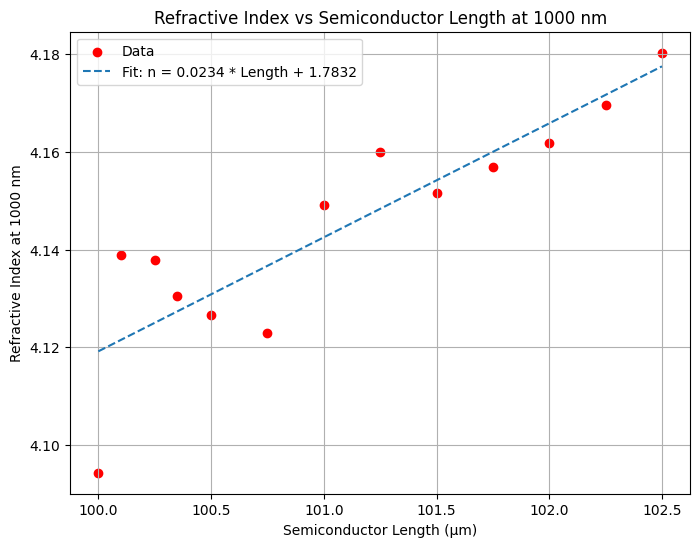

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define target wavelength
target_wavelength = 1000
initial_length = 100  # µm

# Convert strain % to semiconductor lengths (L = L0 * (1 + strain/100))
semiconductor_lengths = [initial_length * (1 + pstress / 100) for pstress in pstress_values]

# Extract refractive index at 1000 nm for each strain
n_at_target = []

for i, (wavelengths, refractive_indices) in enumerate(zip(all_wavelengths, all_refractive_indices)):
    # Check if lengths match; if not, adjust
    if len(wavelengths) != len(refractive_indices):
        print(f"Warning: Length mismatch at index {i}. Adjusting data...")
        min_len = min(len(wavelengths), len(refractive_indices))
        wavelengths = np.array(wavelengths[:min_len])
        refractive_indices = np.array(refractive_indices[:min_len])

    # Sort wavelengths and refractive indices
    sorted_indices = np.argsort(wavelengths)
    wavelengths = wavelengths[sorted_indices]
    refractive_indices = refractive_indices[sorted_indices]

    # Check if target wavelength is within range
    if target_wavelength < min(wavelengths) or target_wavelength > max(wavelengths):
        print(f"Warning: {target_wavelength} nm is outside the interpolation range for index {i}.")
        continue

    # Interpolate to find n at the target wavelength
    # Ensure wavelengths are in ascending order before interpolation
    sorted_indices = np.argsort(wavelengths)
    wavelengths = np.array(wavelengths)[sorted_indices]
    refractive_indices = np.array(refractive_indices)[sorted_indices]

    n_at_target.append(np.interp(target_wavelength, wavelengths, refractive_indices))


# Ensure we have valid data before fitting
if len(n_at_target) == 0:
    raise ValueError("No valid refractive index values found for the target wavelength.")

# Define linear fit function
def linear_fit(x, a, b):
    return a * x + b

# Perform curve fitting using semiconductor lengths instead of strain
popt, pcov = curve_fit(linear_fit, semiconductor_lengths[:len(n_at_target)], n_at_target)

# Generate smooth length values for plotting
length_smooth = np.linspace(min(semiconductor_lengths), max(semiconductor_lengths), 100)
n_smooth = linear_fit(length_smooth, *popt)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(semiconductor_lengths[:len(n_at_target)], n_at_target, label="Data", color='r')
plt.plot(length_smooth, n_smooth, label=f"Fit: n = {popt[0]:.4f} * Length + {popt[1]:.4f}", linestyle="--")
plt.xlabel("Semiconductor Length (µm)")
plt.ylabel(f"Refractive Index at {target_wavelength} nm")
plt.title(f"Refractive Index vs Semiconductor Length at {target_wavelength} nm")
plt.legend()
plt.grid(True)
plt.show()


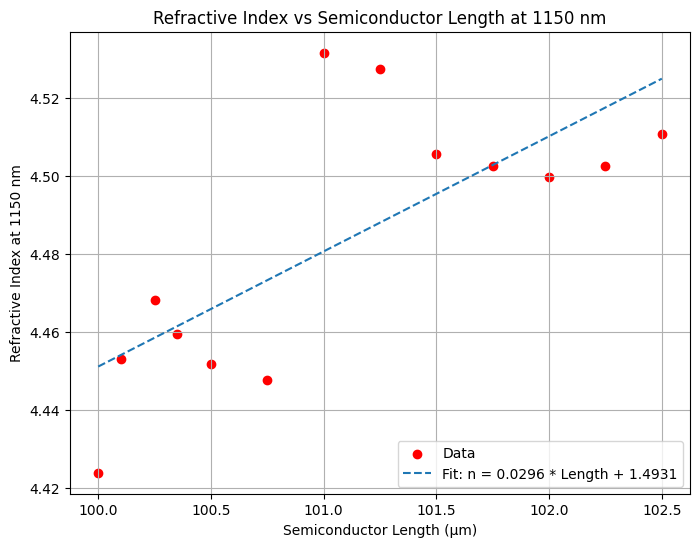

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define target wavelength
target_wavelength = 1150
initial_length = 100  # µm

# Convert strain % to semiconductor lengths (L = L0 * (1 + strain/100))
semiconductor_lengths = [initial_length * (1 + pstress / 100) for pstress in pstress_values]

# Extract refractive index at 1000 nm for each strain
n_at_target = []

for i, (wavelengths, refractive_indices) in enumerate(zip(all_wavelengths, all_refractive_indices)):
    # Check if lengths match; if not, adjust
    if len(wavelengths) != len(refractive_indices):
        print(f"Warning: Length mismatch at index {i}. Adjusting data...")
        min_len = min(len(wavelengths), len(refractive_indices))
        wavelengths = np.array(wavelengths[:min_len])
        refractive_indices = np.array(refractive_indices[:min_len])

    # Sort wavelengths and refractive indices
    sorted_indices = np.argsort(wavelengths)
    wavelengths = wavelengths[sorted_indices]
    refractive_indices = refractive_indices[sorted_indices]

    # Check if target wavelength is within range
    if target_wavelength < min(wavelengths) or target_wavelength > max(wavelengths):
        print(f"Warning: {target_wavelength} nm is outside the interpolation range for index {i}.")
        continue

    # Interpolate to find n at the target wavelength
    # Ensure wavelengths are in ascending order before interpolation
    sorted_indices = np.argsort(wavelengths)
    wavelengths = np.array(wavelengths)[sorted_indices]
    refractive_indices = np.array(refractive_indices)[sorted_indices]

    n_at_target.append(np.interp(target_wavelength, wavelengths, refractive_indices))


# Ensure we have valid data before fitting
if len(n_at_target) == 0:
    raise ValueError("No valid refractive index values found for the target wavelength.")

# Define linear fit function
def linear_fit(x, a, b):
    return a * x + b

# Perform curve fitting using semiconductor lengths instead of strain
popt, pcov = curve_fit(linear_fit, semiconductor_lengths[:len(n_at_target)], n_at_target)

# Generate smooth length values for plotting
length_smooth = np.linspace(min(semiconductor_lengths), max(semiconductor_lengths), 100)
n_smooth = linear_fit(length_smooth, *popt)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(semiconductor_lengths[:len(n_at_target)], n_at_target, label="Data", color='r')
plt.plot(length_smooth, n_smooth, label=f"Fit: n = {popt[0]:.4f} * Length + {popt[1]:.4f}", linestyle="--")
plt.xlabel("Semiconductor Length (µm)")
plt.ylabel(f"Refractive Index at {target_wavelength} nm")
plt.title(f"Refractive Index vs Semiconductor Length at {target_wavelength} nm")
plt.legend()
plt.grid(True)
plt.show()


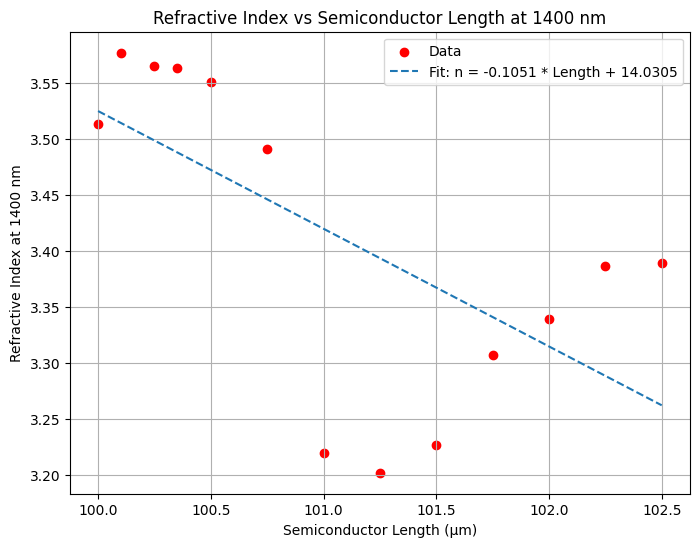

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define target wavelength
target_wavelength = 1400
initial_length = 100  # µm

# Convert strain % to semiconductor lengths (L = L0 * (1 + strain/100))
semiconductor_lengths = [initial_length * (1 + pstress / 100) for pstress in pstress_values]

# Extract refractive index at 1000 nm for each strain
n_at_target = []

for i, (wavelengths, refractive_indices) in enumerate(zip(all_wavelengths, all_refractive_indices)):
    # Check if lengths match; if not, adjust
    if len(wavelengths) != len(refractive_indices):
        print(f"Warning: Length mismatch at index {i}. Adjusting data...")
        min_len = min(len(wavelengths), len(refractive_indices))
        wavelengths = np.array(wavelengths[:min_len])
        refractive_indices = np.array(refractive_indices[:min_len])

    # Sort wavelengths and refractive indices
    sorted_indices = np.argsort(wavelengths)
    wavelengths = wavelengths[sorted_indices]
    refractive_indices = refractive_indices[sorted_indices]

    # Check if target wavelength is within range
    if target_wavelength < min(wavelengths) or target_wavelength > max(wavelengths):
        print(f"Warning: {target_wavelength} nm is outside the interpolation range for index {i}.")
        continue

    # Interpolate to find n at the target wavelength
    # Ensure wavelengths are in ascending order before interpolation
    sorted_indices = np.argsort(wavelengths)
    wavelengths = np.array(wavelengths)[sorted_indices]
    refractive_indices = np.array(refractive_indices)[sorted_indices]

    n_at_target.append(np.interp(target_wavelength, wavelengths, refractive_indices))


# Ensure we have valid data before fitting
if len(n_at_target) == 0:
    raise ValueError("No valid refractive index values found for the target wavelength.")

# Define linear fit function
def linear_fit(x, a, b):
    return a * x + b

# Perform curve fitting using semiconductor lengths instead of strain
popt, pcov = curve_fit(linear_fit, semiconductor_lengths[:len(n_at_target)], n_at_target)

# Generate smooth length values for plotting
length_smooth = np.linspace(min(semiconductor_lengths), max(semiconductor_lengths), 100)
n_smooth = linear_fit(length_smooth, *popt)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(semiconductor_lengths[:len(n_at_target)], n_at_target, label="Data", color='r')
plt.plot(length_smooth, n_smooth, label=f"Fit: n = {popt[0]:.4f} * Length + {popt[1]:.4f}", linestyle="--")
plt.xlabel("Semiconductor Length (µm)")
plt.ylabel(f"Refractive Index at {target_wavelength} nm")
plt.title(f"Refractive Index vs Semiconductor Length at {target_wavelength} nm")
plt.legend()
plt.grid(True)
plt.show()
